# Click-Through Rate Prediction :
#### Predict whether a mobile ad will be clicked using tensorflow random forests algorithms.

By **Ian SOBRAL**

## Table of Contents

* [1. Introduction](#1)
* [2. Initial kaggle configurations](#2)
* [3. Libraries used in the project](#3)
* [4. Data visualization](#4)
* [5. Most influential factors](#5)
* [6. Data sets creation](#6)
* [7. Simple model](#7)
* [8. Complete model](#8)
* [9. Predictions on test dataset](#9)
* [10. Conclusions](#10)

## 1. Introduction <a id="1"></a>

Click-through rate (CTR) is a very common way to predict if a certain ad will be clicked or not. This metric is the relationship between users who clicked on the ad and all users (taking into account those who clicked and those who did not). This way we can have a good visibility on whether an advertisement is effective or not.

The objectif of this project is to build a predicting model for CTR based on the following Avazu's data set, available on the kaggle website: https://www.kaggle.com/c/avazu-ctr-prediction/data.

In other words, we want to predict the probability that an user is going to clik or not on a given advertisement.

## 2. Initial kaggle configurations <a id="2"></a>

Install "kaggle" library and configure the "kaggle.json" file to have access to the dataset if necessary:

In [2]:
#!pip install kaggle

In [3]:
#!mkdir ~/.kaggle

In [4]:
#!cp kaggle.json ~/.kaggle

Download the dataset:

In [5]:
#!kaggle competitions download -c avazu-ctr-prediction

## 3. Libraries used in the project <a id="3"></a>

You will find down below all the libraries used in the project:

In [76]:
import pandas as pd
pd.set_option("display.max_columns", None)
#import zipfile
import gzip
import random
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow_decision_forests as tfdf

## 4. Data visualization<a id="4"></a>

Extracting the .zip file :

In [7]:
# with zipfile.ZipFile("avazu-ctr-prediction.zip", 'r') as z:
#     z.extractall()

The extracted files are the following (the description was retrieved from the kaggle competition) :

- **train.gz** : Training set. 10 days of click-through data, ordered chronologically. Non-clicks and clicks are subsampled according to different strategies

- **test.gz** : Test set. 1 day of ads to for testing your model predictions

- **sampleSubmission.gz** : Sample submission file in the correct format.

On this data set, we have more than 40 million entries! In order to train the model faster, we will randomly take about 5% of this data set, which represents about 2 million rows to create the train set. 

To create the cross-validation (cv) set, we will take 1% of 2 million which is 200 thousand.

The test set will be used for the submission to the kaggle website at the end of the project.

In [8]:
n = 40428967 #number of rows in "train.gz"
s = 2200000 #sample size to be splitted on train and cv datasets

skiprows = sorted(random.sample(range(1,n+1),n-s))

To be able to read and to work with the data, we will need to do the following:

- Convert the data types to more user-friendly ones :

In [9]:
dtypes_converter = {
    'id': np.dtype(int),
    'click': np.dtype(int),
    'hour': str,
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21': np.dtype(int)
}

- Convert the timestamp from the "hour" column to a "date-time" format :

In [10]:
dparser = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

Finally, we can open the 'train.gz' file :

In [ ]:
with gzip.open('train.gz') as f:
    df = pd.read_csv(f, parse_dates=["hour"], date_parser=dparser, dtype=dtypes_converter, skiprows=skiprows)

Check the size of the data set:

In [12]:
df.shape

(2200000, 24)

Visualize the data:

In [13]:
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,10004181428767727519,0,2014-10-21,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b7a69808,158e4944,1,0,6558,320,50,571,2,39,-1,32
1,10006557235872316145,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ac77b71a,d787e91b,1,0,15699,320,50,1722,0,35,-1,79
2,1001082718558099372,0,2014-10-21,1005,0,85f751fd,c4e18dd6,50e219e0,1779deee,2347f47a,f95efa07,a99f214a,5a96d22e,9e3836ff,1,0,18993,320,50,2161,0,35,-1,157
3,1001179289293608710,0,2014-10-21,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,f7c9ee04,56f254f5,1,0,17914,320,50,2043,2,39,-1,32
4,10014630626523032142,0,2014-10-21,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0345a137,3bd9e8e7,1,0,15702,320,50,1722,0,35,100083,79


We can see that some data do not make sense, the reason is that they have been encrypted by Avazu for privacy reasons.

Furthermore, since the hour and the time are displayed together on the "hour" parameter, we can separe them into two new columns : "actual_hour" and "weekday". 

We will take the day of the week as a parameter rather than the actual date, because since the goal of the model is to predict clicks for future dates, days of the week seem to be much more useful

In [11]:
def split_hour_week(df):
    df["actual_hour"]=df["hour"].dt.hour
    df["weekday"]=df["hour"].dt.weekday
    df.drop('hour', axis=1, inplace=True)

In [ ]:
split_hour_week(df)

In [16]:
df.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,actual_hour,weekday
0,10004181428767727519,0,1005,1,0c2fe9d6,27e3c518,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b7a69808,158e4944,1,0,6558,320,50,571,2,39,-1,32,0,1
1,10006557235872316145,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ac77b71a,d787e91b,1,0,15699,320,50,1722,0,35,-1,79,0,1
2,1001082718558099372,0,1005,0,85f751fd,c4e18dd6,50e219e0,1779deee,2347f47a,f95efa07,a99f214a,5a96d22e,9e3836ff,1,0,18993,320,50,2161,0,35,-1,157,0,1
3,1001179289293608710,0,1005,1,e023ba3e,75f9ddc3,f028772b,ecad2386,7801e8d9,07d7df22,a99f214a,f7c9ee04,56f254f5,1,0,17914,320,50,2043,2,39,-1,32,0,1
4,10014630626523032142,0,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,0345a137,3bd9e8e7,1,0,15702,320,50,1722,0,35,100083,79,0,1


Looking at the data types :

In [17]:
df.dtypes

id                  uint64
click                int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
actual_hour          int64
weekday              int64
dtype: object

We would like to convert the data that are objects to integers with Python's built-in hash function so that we can train the model more easily. Doing so:

In [12]:
def hash_converter(df):
    for feat in df.columns:
        if df[feat].dtypes == object:
            df[feat]=df[feat].apply(lambda x : hash(x) % (10 ** 8))

In [19]:
hash_converter(df)

In [20]:
df.head()

,id,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,actual_hour,weekday
0,10004181428767727519,0,1005,1,16871230,278783,68987348,21296553,19803410,54082361,10247907,23766115,53303355,1,0,6558,320,50,571,2,39,-1,32,0,1
1,10006557235872316145,0,1005,0,77416566,45450440,68987348,21296553,19803410,54082361,10247907,22171795,39340179,1,0,15699,320,50,1722,0,35,-1,79,0,1
2,1001082718558099372,0,1005,0,58871977,47101692,34961570,28512083,52117907,3237031,10247907,45897290,21967382,1,0,18993,320,50,2161,0,35,-1,157,0,1
3,1001179289293608710,0,1005,1,38174238,22481631,38489621,21296553,19803410,54082361,10247907,46375993,79552073,1,0,17914,320,50,2043,2,39,-1,32,0,1
4,10014630626523032142,0,1005,0,77416566,45450440,68987348,21296553,19803410,54082361,10247907,30617252,51475712,1,0,15702,320,50,1722,0,35,100083,79,0,1


## 5. Most influential factors<a id="5"></a>

Now we are going to search the factors that are most influetial regarding the "click" feature.

First, we are going to check the overall click percentage of all cases:

In [21]:
df['click'].value_counts()/len(df)

0    0.830238
1    0.169762
Name: click, dtype: float64

With this result we can observe that our click through rate (CTR) of the entire dataset is approximately : 83% of "non" clicks ans 17% of clicks

Furthermore, some functions were created to evaluate the features individually:

- Bar graph of the number of clicks per feature

In [22]:
def plotClicks(feat, df,size):
    df.groupby(feat).agg({'click':'sum'}).plot(xlabel=feat,ylabel='clicks',kind='bar',figsize=size)

- CTR by feature:

In [23]:
def CTR(feat,df):
    number_of_clicks=df.groupby(feat).sum()
    number_of_users=df.groupby(feat).size().to_frame()
    return (number_of_clicks['click']/number_of_users[0]).to_frame()

- Bar graph of the CTR by feature:

In [24]:
def plotCTR(feat,df,size):
    return CTR(feat,df).plot(xlabel=feat,ylabel='CTR',kind='bar',figsize=size, legend=False)

- Impressions percentage:

In [25]:
def imp_p(feat,df):
    return df[feat].value_counts(normalize=True)*100

- Informations about the impressions:

In [26]:
def imp_info(feat,df):
    max_imp=round(max(imp_p(feat,df)),2)
    nfeat=df[feat].nunique()
    info1=f"The total number of {feat} features is {nfeat}."
    info2=f"The max percentage impression of an individual feature is {max_imp}%."
    return info1+"\n"+info2

Now we are going to check the influence of each parameter regarding if the user clicked or not on the ad.

### 5.1. Actual Hour<a id="5.1."></a>

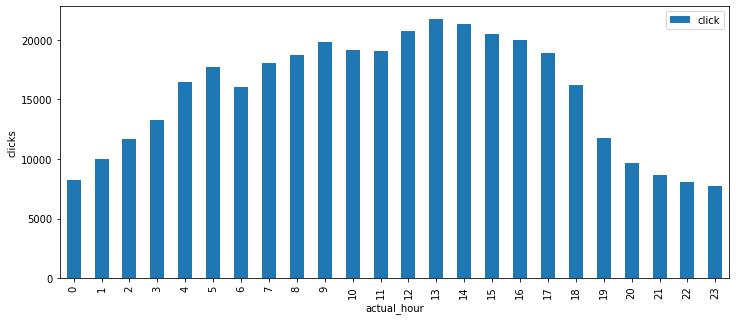

In [27]:
plotClicks("actual_hour", df,(12,5))

The most of clicks happened between 12:00 and 14:00 and the less of clicks happened between 23:00 and 01:00.

We can observe that the "actual_hour" parameter can be useful for our estimation

Now we are going to display this feature in a bar graph against the CTR:

<AxesSubplot:xlabel='actual_hour', ylabel='CTR'>

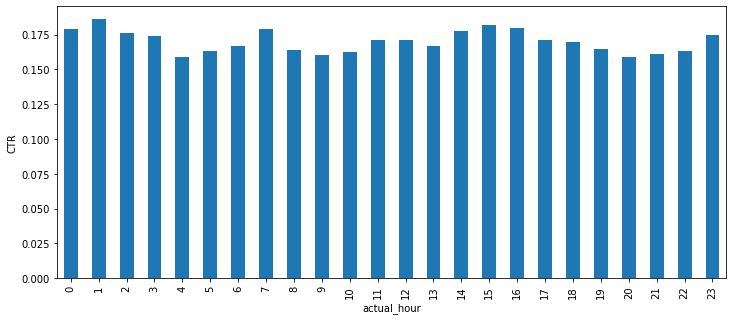

In [28]:
plotCTR("actual_hour",df,(12,5))

Viewing the data in this way, we see that the CTR is not highest between 12:00 and 14:00, as we could have expected.

Now we can visualize the impressions and other properties :

In [29]:
print(imp_info("actual_hour",df))
print("Features by percentage:")
imp_p("actual_hour",df)

The total number of actual_hour features is 24.
The max percentage impression of an individual feature is 5.92%.
Features by percentage:


13    5.915273
9     5.603182
12    5.516455
14    5.455955
10    5.349727
8     5.195773
15    5.127818
16    5.068500
11    5.058364
17    5.034045
5     4.928864
4     4.700364
7     4.589636
6     4.378500
18    4.344227
3     3.455000
19    3.257864
2     3.007364
20    2.760182
21    2.444182
1     2.439727
22    2.252955
0     2.100182
23    2.015864
Name: actual_hour, dtype: float64

The impressions are almost equaly divided by feature.

### 5.2. Weekday<a id="5.2"></a>

Doing the same as we did to the "actual_hour" feature:

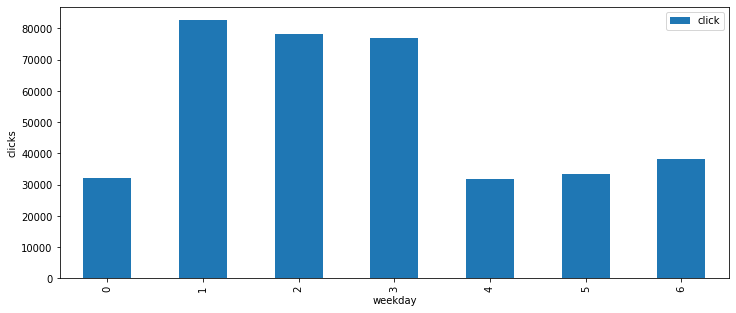

In [30]:
plotClicks("weekday", df, (12,5))

<AxesSubplot:xlabel='weekday', ylabel='CTR'>

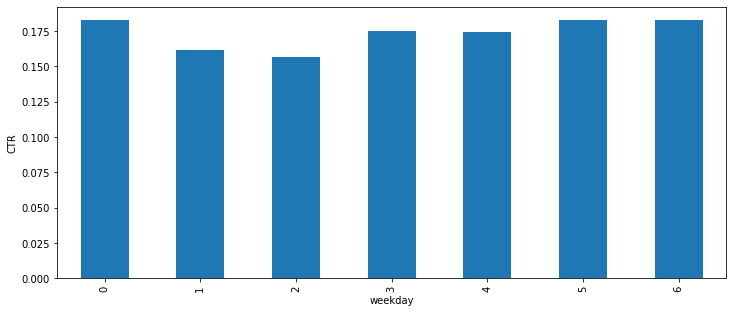

In [31]:
plotCTR("weekday",df, (12,5))

From these graphs, we have : Monday=0, Tuesday=1, Wednesday=2, Thursday=3, Friday=4, Saturday=5 and Sunday=6.

The highest CTR takes place on weekends.

Now, visualizing the impressions:

In [32]:
feat = "weekday"
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

The total number of weekday features is 7.
The max percentage impression of an individual feature is 23.3%.
Features impression by percentage:


1    23.303273
2    22.657955
3    19.985227
6     9.501591
5     8.311318
4     8.260455
0     7.980182
Name: weekday, dtype: float64

### 5.3. Hidden features<a id="5.3"></a>

We can see that the name of some features is displayed with the letter "C" and a number. The reason for this is that they have been hidden by Avazu for privacy reasons, as we have already mentioned. We will call them "Hidden features".

#### Feature "C1":

The total number of C1 features is 7.
The max percentage impression of an individual feature is 91.87%.
Features impression by percentage:


1005    91.867045
1002     5.499636
1010     2.224818
1012     0.286000
1007     0.084864
1001     0.023000
1008     0.014636
Name: C1, dtype: float64

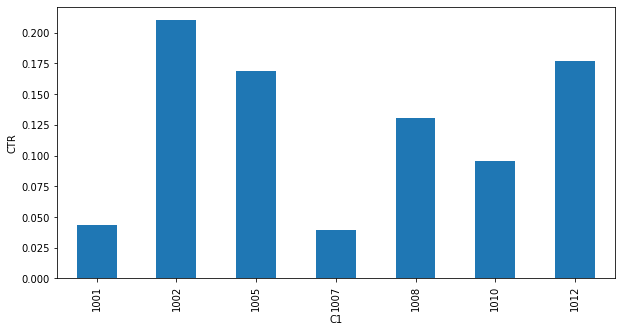

In [33]:
feat = "C1"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

#### Feature "C14":

The total number of C14 features is 2390.
The max percentage impression of an individual feature is 2.35%.
Top 5 features impression by percentage:


4687     2.351000
21611    2.248864
21191    1.893545
21189    1.892455
19772    1.820045
Name: C14, dtype: float64

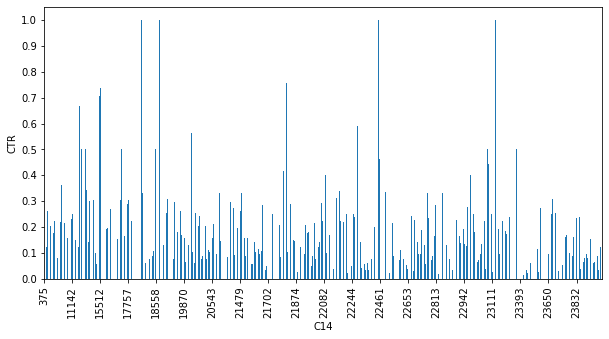

In [34]:
feat = "C14"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### Feature "C15":

The total number of C15 features is 8.
The max percentage impression of an individual feature is 93.29%.
Features impression by percentage:


320     93.292227
300      5.766409
216      0.734409
728      0.184091
120      0.007545
1024     0.006545
480      0.005227
768      0.003545
Name: C15, dtype: float64

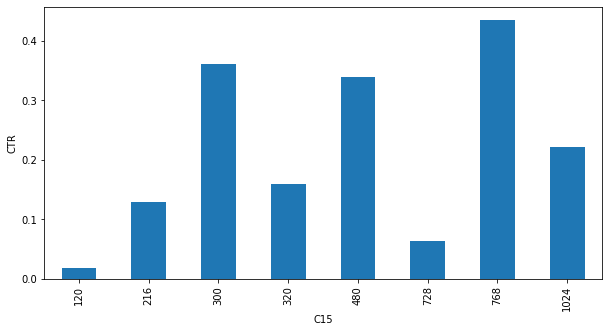

In [35]:
feat = "C15"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

#### Feature "C16":

The total number of C16 features is 9.
The max percentage impression of an individual feature is 94.34%.
Features impression by percentage:


50      94.338591
250      4.462182
36       0.734409
480      0.257864
90       0.184091
20       0.007545
768      0.006545
320      0.005227
1024     0.003545
Name: C16, dtype: float64

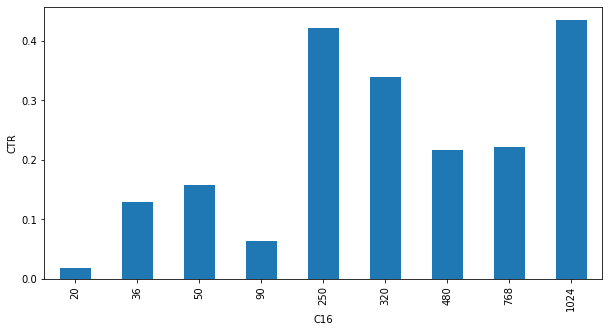

In [36]:
feat = "C16"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

#### Feature "C17":

The total number of C17 features is 425.
The max percentage impression of an individual feature is 11.17%.
Top 5 features impression by percentage:


1722    11.165045
2424     3.786000
2227     3.663818
1800     2.961727
423      2.351000
Name: C17, dtype: float64

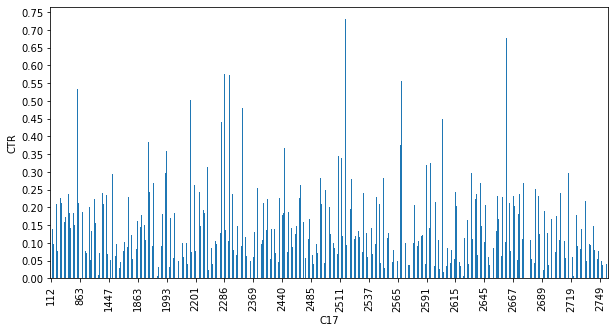

In [37]:
feat = "C17"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### Feature "C18":

The total number of C18 features is 4.
The max percentage impression of an individual feature is 41.89%.
Features impression by percentage:


0    41.892773
3    33.787045
2    17.590409
1     6.729773
Name: C18, dtype: float64

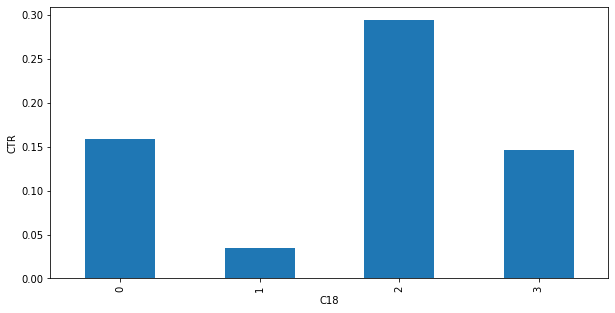

In [38]:
feat = "C18"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

#### Feature "C19":

The total number of C19 features is 66.
The max percentage impression of an individual feature is 30.05%.
Top 5 features impression by percentage:


35     30.050136
39     21.909545
167     7.805182
161     3.926227
47      3.572864
Name: C19, dtype: float64

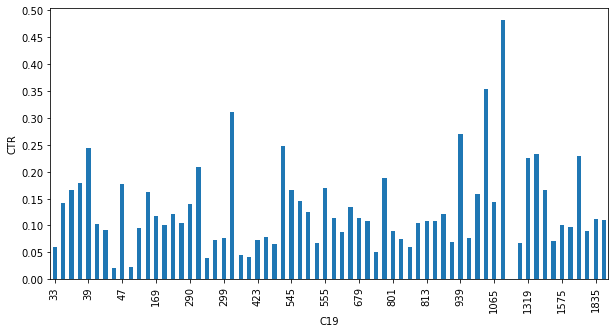

In [39]:
feat = "C19"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### Feature "C20":

The total number of C20 features is 164.
The max percentage impression of an individual feature is 46.87%.
Top 5 features impression by percentage:


-1         46.872000
 100084     6.006045
 100148     4.455273
 100111     4.241182
 100077     3.888500
Name: C20, dtype: float64

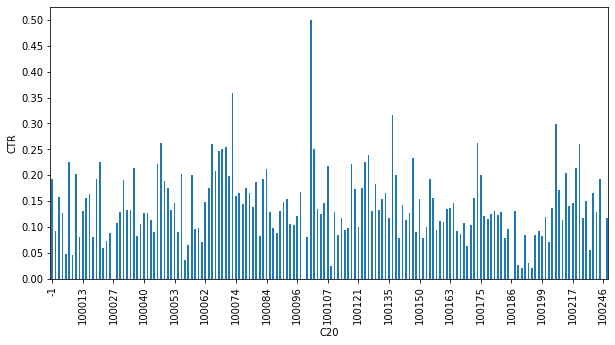

In [40]:
feat = "C20"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### Feature "C21":

The total number of C21 features is 60.
The max percentage impression of an individual feature is 22.01%.
Top 5 features impression by percentage:


23     22.010955
221    12.481909
79     11.417000
48      5.363227
71      5.210409
Name: C21, dtype: float64

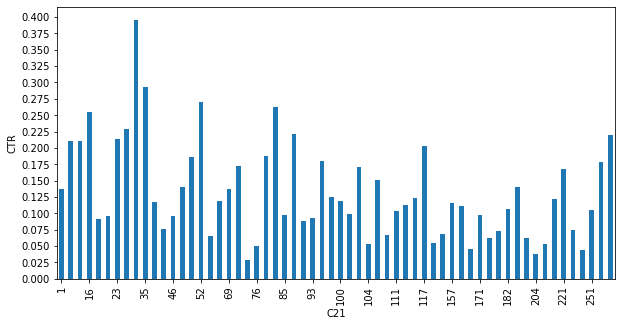

In [41]:
feat = "C21"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

### 5.4. Banner position<a id="5.4"></a>

The total number of banner_pos features is 7.
The max percentage impression of an individual feature is 72.01%.
Features impression by percentage:


0    72.012045
1    27.810227
7     0.106136
2     0.032682
4     0.018864
5     0.014636
3     0.005409
Name: banner_pos, dtype: float64

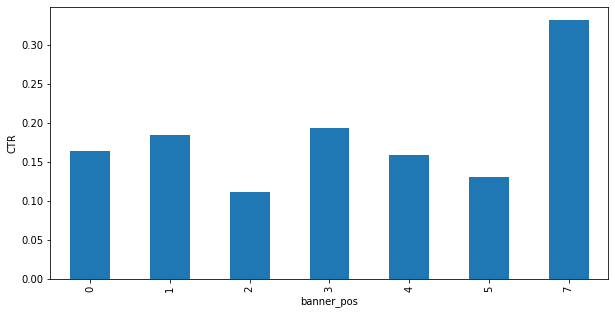

In [42]:
feat = "banner_pos"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

The banner positions 0 and 1 are the most frequent, but the position 7 has the highest CTR.

### 5.5. Site features<a id="5.5"></a>

The site features are the following:

#### site_id:

The total number of site_id features is 3078.
The max percentage impression of an individual feature is 36.11%.
Top 5 features impression by percentage:


58871977    36.109273
77416566    16.037182
69663027     6.528636
47868311     2.367909
47499721     2.254591
Name: site_id, dtype: float64

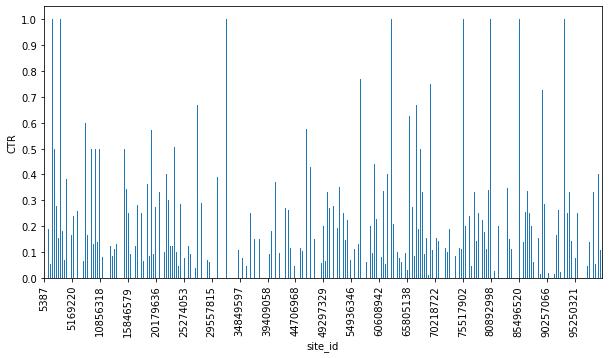

In [43]:
feat = "site_id"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### site_domain:

The total number of site_domain features is 3578.
The max percentage impression of an individual feature is 37.44%.
Top 5 features impression by percentage:


47101692    37.439545
45450440    16.037182
92132807     8.233818
68438688     3.184955
81576619     2.450636
Name: site_domain, dtype: float64

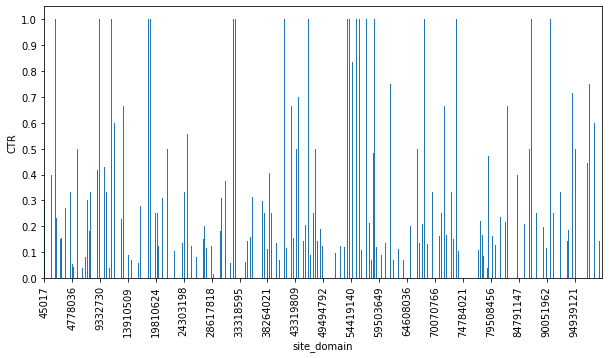

In [44]:
feat = "site_domain"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### site_category:

The total number of site_category features is 21.
The max percentage impression of an individual feature is 40.91%.
Top 5 features impression by percentage:


34961570    40.906682
38489621    31.290136
68987348    18.228591
85396418     7.551091
76012494     0.626364
Name: site_category, dtype: float64

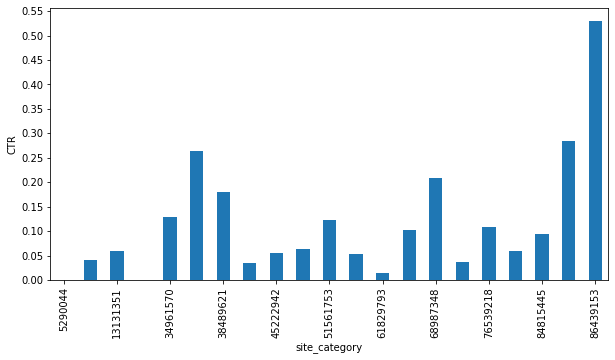

In [45]:
feat = "site_category"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

### 5.6. App features<a id="5.6"></a>

The app features are the following:

#### app_id:

The total number of app_id features is 4062.
The max percentage impression of an individual feature is 63.89%.
Top 5 features impression by percentage:


21296553    63.890727
67221166     3.841909
14726820     2.793000
6779498      1.890182
82374827     1.873409
Name: app_id, dtype: float64

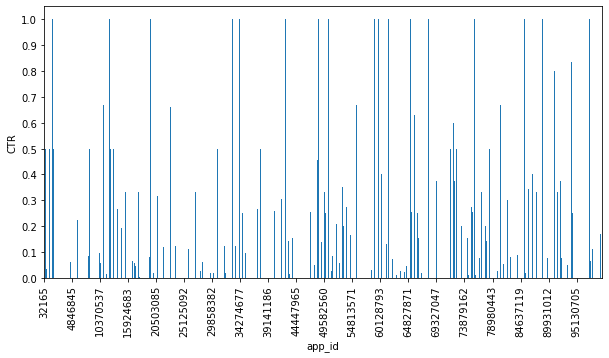

In [46]:
feat = "app_id"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### app_domain:

The total number of app_domain features is 253.
The max percentage impression of an individual feature is 67.36%.
Top 5 features impression by percentage:


19803410    67.365000
52117907    12.921227
62945929     4.648318
3119132      2.793409
95913759     1.890318
Name: app_domain, dtype: float64

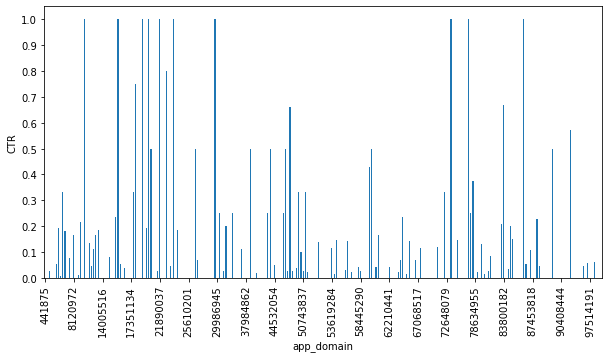

In [47]:
feat = "app_domain"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### app_category:

The total number of app_category features is 28.
The max percentage impression of an individual feature is 64.72%.
Top 5 features impression by percentage:


54082361    64.723864
77290787    23.631045
17669737     4.316591
559247       3.616091
3237031      2.824500
Name: app_category, dtype: float64

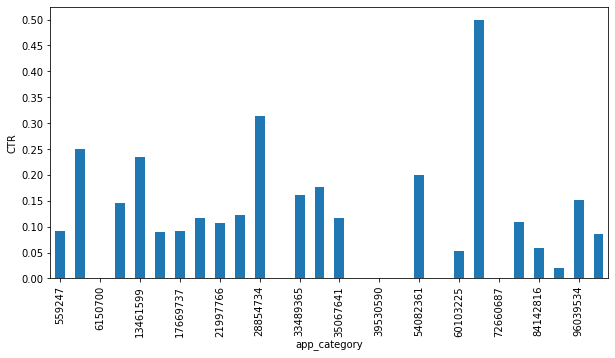

In [48]:
feat = "app_category"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

### 5.7. Device features<a id="5.7"></a>

The device features are the following:

#### device_id:

In [49]:
feat = "device_id"
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

The total number of device_id features is 300876.
The max percentage impression of an individual feature is 82.56%.
Top 5 features impression by percentage:


10247907    82.561545
46536917     0.053545
98726390     0.049773
10968229     0.035182
22936040     0.024227
Name: device_id, dtype: float64

#### device_ip:

In [50]:
feat = "device_ip"
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

The total number of device_ip features is 1031270.
The max percentage impression of an individual feature is 0.51%.
Top 5 features impression by percentage:


56672657    0.513682
27021711    0.334364
43055436    0.219227
22084914    0.217955
91657272    0.214318
Name: device_ip, dtype: float64

#### device_model:

The total number of device_model features is 5855.
The max percentage impression of an individual feature is 6.06%.
Top 5 features impression by percentage:


71405640    6.060045
18363807    3.516136
39340179    3.459682
58278248    1.910591
33949426    1.831000
Name: device_model, dtype: float64

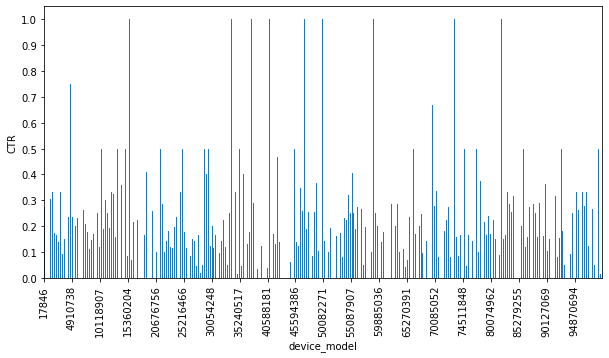

In [51]:
feat = "device_model"
plotCTR(feat,df,(10,5)).locator_params(nbins=20)
print(imp_info(feat,df))
print("Top 5 features impression by percentage:")
imp_p(feat,df)[0:5]

#### device_type:

The total number of device_type features is 5.
The max percentage impression of an individual feature is 92.28%.
Features impression by percentage:


1    92.275500
0     5.499636
4     1.912909
5     0.311909
2     0.000045
Name: device_type, dtype: float64

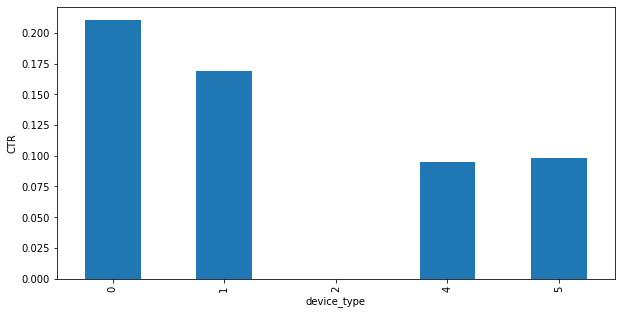

In [52]:
feat="device_type"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

#### device_conn_type:

The total number of device_conn_type features is 4.
The max percentage impression of an individual feature is 86.3%.
Features impression by percentage:


0    86.297818
2     8.206864
3     5.390591
5     0.104727
Name: device_conn_type, dtype: float64

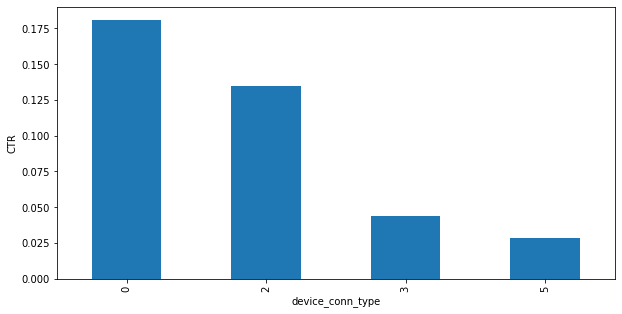

In [53]:
feat="device_conn_type"
plotCTR(feat,df,(10,5))
print(imp_info(feat,df))
print("Features impression by percentage:")
imp_p(feat,df)

## 6. Data sets creation<a id="6"></a>

By analyzing the previous features, we can see that some values do not seem to be very relevant for prediction. 

For example, the device_ip feature has 962460 unique values. The influence of this parameter can be difficult to understand at first glance and the impression of each value is less than 0.5%.

So, to start, we will eliminate some features of the data set to build a simplified random forests model. Then we will build a complete model and compare it with the simplified one.

We will drop the "id" feature for both models.

First we shuffle the original dataframe:

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

Then we can extract its simplified version:

In [55]:
df_simp = copy.copy(df)

In [13]:
def drop_feat(df, feat_to_drop=['id','C14','C17','site_id','site_domain','app_id','app_domain','device_id','device_ip','device_model']):
    for f in feat_to_drop :
        df.drop(f, axis=1, inplace=True)

In [57]:
drop_feat(df_simp)

In [58]:
drop_feat(df,['id'])

In [59]:
df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,actual_hour,weekday
0,0,1005,0,58871977,47101692,34961570,44098617,52117907,77290787,10247907,41134101,58323650,1,0,22738,320,50,2636,0,47,100111,70,6,2
1,1,1005,1,69663027,92132807,38489621,21296553,19803410,54082361,10247907,22205911,78412339,1,0,17262,320,50,1872,3,39,-1,23,4,3
2,0,1002,0,73488799,98389258,34961570,21296553,19803410,54082361,56715572,13779635,44433699,0,0,21789,320,50,2512,2,291,-1,52,14,2
3,0,1005,0,58871977,47101692,34961570,82414098,35249761,77290787,10247907,73360954,28309763,1,0,23625,320,50,2706,3,937,100155,61,23,2
4,0,1005,0,58871977,47101692,34961570,48052539,52117907,559247,37555679,70575167,93924659,1,0,23143,320,50,2665,0,35,-1,221,1,2


In [60]:
df_simp.head()

,click,C1,banner_pos,site_category,app_category,device_type,device_conn_type,C15,C16,C18,C19,C20,C21,actual_hour,weekday
0,0,1005,0,34961570,77290787,1,0,320,50,0,47,100111,70,6,2
1,1,1005,1,38489621,54082361,1,0,320,50,3,39,-1,23,4,3
2,0,1002,0,34961570,54082361,0,0,320,50,2,291,-1,52,14,2
3,0,1005,0,34961570,77290787,1,0,320,50,3,937,100155,61,23,2
4,0,1005,0,34961570,559247,1,0,320,50,0,35,-1,221,1,2


Dividing the dataframe into train and cv dataframes:

In [61]:
train_simp=df_simp.loc[0:1999999]
cv_simp=df_simp.loc[2000000:]

In [62]:
train=df.loc[0:1999999]
cv=df.loc[2000000:]

In [63]:
train_simp.shape, train.shape

((2000000, 15), (2000000, 24))

In [64]:
cv_simp.shape, cv.shape

((200000, 15), (200000, 24))

Saving all dataframes to a .csv file (if needed):

In [67]:
df.to_csv("df.csv", index = False)

train.to_csv("train_all.csv", index = False)
cv.to_csv("cv_all.csv", index = False)

train_simp.to_csv("train_simp.csv", index = False)
cv_simp.to_csv("cv_simp.csv", index = False)

## 7. Simple model<a id="7"></a>

### 7.1. Decision forests model with default settings

Loading the data set (if needed):

In [66]:
train_simp=pd.read_csv('train_simp.csv')
cv_simp=pd.read_csv('cv_simp.csv')

Converting the data frames to tensorflow datasets:

In [ ]:
cv_simp_tf = tfdf.keras.pd_dataframe_to_tf_dataset(cv_simp, label="click")

In [ ]:
train_simp_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train_simp, label="click")

Training the model with default settings:

In [8]:
model = tfdf.keras.RandomForestModel()

Use /tmp/tmpmbx52cs8 as temporary training directory


In [9]:
model.fit(train_simp_tf)

Starting reading the dataset
1992/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:09.571145
Training model
Model trained in 0:04:34.253242
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


2000/2000 [==============================] - 290s 144ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Evaluating the model with the cv set:

In [8]:
model.compile(metrics=["accuracy"])
print(model.evaluate(cv_simp_tf))

200/200 [==============================] - 6s 29ms/step - loss: 0.0000e+00 - accuracy: 0.8328
[0.0, 0.8327950239181519]


Visualizing one of the threes from the decision forest:

In [11]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)

Some details about the actual model:

In [13]:
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (14):
	C1
	C15
	C16
	C18
	C19
	C20
	C21
	actual_hour
	app_category
	banner_pos
	device_conn_type
	device_type
	site_category
	weekday

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.          "__LABEL" 14.086540 ################
    2.      "device_type" 12.379652 #############
    3.               "C1" 12.360483 #############
    4.              "C15" 11.002553 ###########
    5.       "banner_pos" 10.475877 ##########
    6.          "weekday" 10.369408 ##########
    7.      "actual_hour"  9.338531 #########
    8. "device_conn_type"  9.021443 ########
    9.    "site_category"  8.111001 #######
   10.              "C1

To evaluate the quality of the model, we are going to plot the training logs:

In [13]:
def trainingLogs(model):
    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()

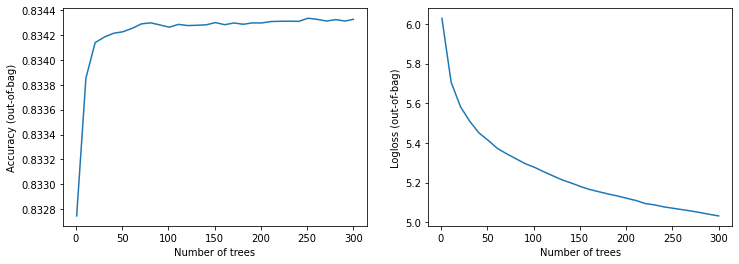

In [13]:
trainingLogs(model)

### 7.2. Decision forests model with Hyperparameter Tuning

Now we are going to see if wee can get a better model with some Hyperparameters Tuning.

To keep simple, we will test the following hyperparameters:

* Number of trees:

In [14]:
model2 = tfdf.keras.RandomForestModel(num_trees=500)

Use /tmp/tmpsr5c2mkl as temporary training directory


In [15]:
model2.fit(train_simp_tf)

Starting reading the dataset
1998/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:07.751863
Training model
Model trained in 0:07:59.101663
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


2000/2000 [==============================] - 504s 252ms/step


In [19]:
model2.compile(metrics=["accuracy"])
print(model2.evaluate(cv_simp_tf))

200/200 [==============================] - 21s 103ms/step - loss: 0.0000e+00 - accuracy: 0.8327
[0.0, 0.8327400088310242]


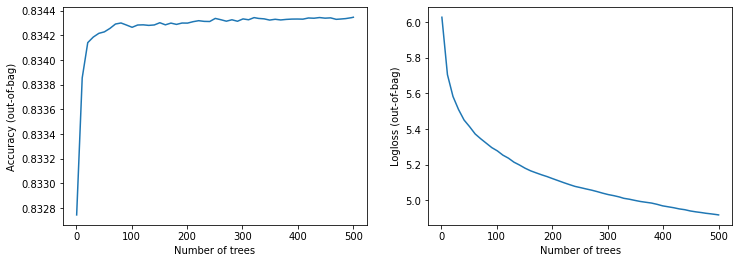

In [18]:
trainingLogs(model2)

The number of trees doesn't seem to change too much the results.

- Growing strategy

In [20]:
model3 = tfdf.keras.RandomForestModel(growing_strategy="BEST_FIRST_GLOBAL")

Use /tmp/tmpfbmym51n as temporary training directory


In [21]:
model3.fit(train_simp_tf)

Starting reading the dataset
1992/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:12.790015
Training model
Model trained in 0:02:00.116437
Compiling model
2000/2000 [==============================] - 133s 66ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


In [22]:
model3.compile(metrics=["accuracy"])
print(model3.evaluate(cv_simp_tf))

200/200 [==============================] - 4s 18ms/step - loss: 0.0000e+00 - accuracy: 0.8306
[0.0, 0.8306149840354919]


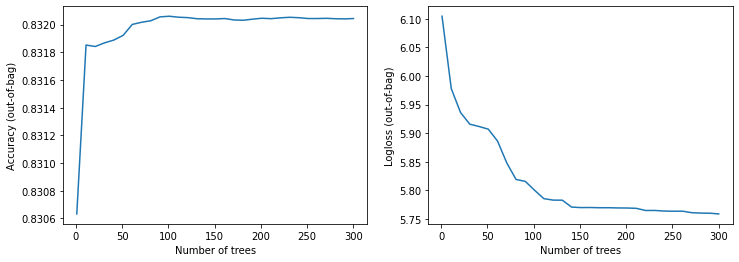

In [24]:
trainingLogs(model3)

This time we had a much quicker convergence. But a worst result.

- Combining both parameters:

In [30]:
model4 = tfdf.keras.RandomForestModel(num_trees=500,growing_strategy="BEST_FIRST_GLOBAL")

Use /tmp/tmp3tewkxq_ as temporary training directory


In [31]:
model4.fit(train_simp_tf)

Starting reading the dataset
1998/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:12.937223
Training model
Model trained in 0:03:22.853127
Compiling model
2000/2000 [==============================] - 216s 108ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


In [32]:
model4.compile(metrics=["accuracy"])
print(model4.evaluate(cv_simp_tf))

200/200 [==============================] - 6s 29ms/step - loss: 0.0000e+00 - accuracy: 0.8306
[0.0, 0.8306149840354919]


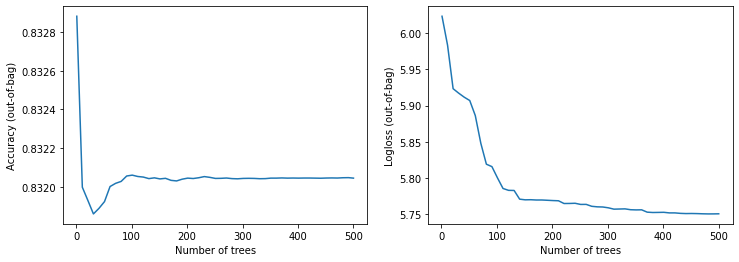

In [34]:
trainingLogs(model4)

Combining both parameters does not seem to be helpful.

### 7.3. Gradient Boosted trees model

We will now see if it is possible to optimize the model by using a different algorithm.

To do so, we will use the Gradient Boosted Trees model (GBT model). According to the tensorflow documentation, a GBT model "is a set of shallow decision trees trained sequentially. Each tree is trained to predict and then "correct" for the errors of the previously trained trees (more precisely each tree predict the gradient of the loss relative to the model output)".

In [5]:
model_gbt1 = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmprifck8uq as temporary training directory


In [6]:
model_gbt1.fit(train_simp_tf)

Starting reading the dataset
1998/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:15.297293
Training model
Model trained in 0:07:57.690340
Compiling model
2000/2000 [==============================] - 493s 245ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [7]:
model_gbt1.compile(metrics=["accuracy"])
print(model_gbt1.evaluate(cv_simp_tf))

200/200 [==============================] - 2s 7ms/step - loss: 0.0000e+00 - accuracy: 0.8325
[0.0, 0.8324949741363525]


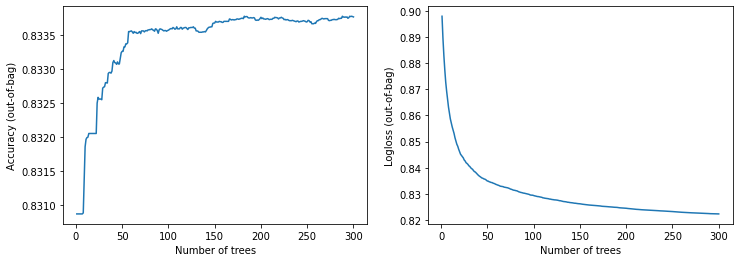

In [16]:
trainingLogs(model_gbt1)

Our logloss has stabilized at about 0.83! This is a much better result than the previous one.

- Now with hyperparameter tuning:

In [9]:
model_gbt2 = tfdf.keras.GradientBoostedTreesModel(num_trees=500,growing_strategy="BEST_FIRST_GLOBAL")

Use /tmp/tmps062enmi as temporary training directory


In [10]:
model_gbt2.fit(train_simp_tf)

Starting reading the dataset
1995/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:13.020286
Training model
Model trained in 0:10:48.146676
Compiling model
2000/2000 [==============================] - 661s 331ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


In [11]:
model_gbt2.compile(metrics=["accuracy"])
print(model_gbt1.evaluate(cv_simp_tf))

200/200 [==============================] - 1s 5ms/step - loss: 0.0000e+00 - accuracy: 0.8325
[0.0, 0.8324949741363525]


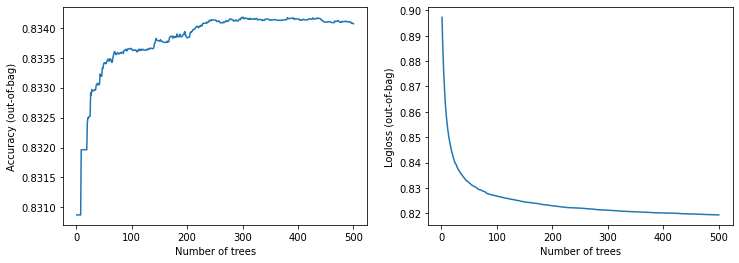

In [18]:
trainingLogs(model_gbt2)

Tuning the parameters for this model does not seem to help too much the results neither.

## 8. Complete model<a id="8"></a>

Now we are going to build the model with all parameters to see if our loss gets any better.

In [7]:
train=pd.read_csv('train_all.csv')
cv=pd.read_csv('cv_all.csv')

In [ ]:
cv_tf = tfdf.keras.pd_dataframe_to_tf_dataset(cv, label="click")
train_tf = tfdf.keras.pd_dataframe_to_tf_dataset(train, label="click")

In [24]:
model5 = tfdf.keras.RandomForestModel()

Use /tmp/tmp79zzfscg as temporary training directory


In [25]:
model5.fit(train_tf)

Starting reading the dataset
1997/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:20.823138
Training model
Model trained in 0:07:39.938770
Compiling model


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestOptPred" built
[INFO kernel.cc:1001] Use fast generic engine


2000/2000 [==============================] - 490s 244ms/step
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [27]:
model5.compile(metrics=["accuracy"])
print(model5.evaluate(cv_tf))

200/200 [==============================] - 12s 57ms/step - loss: 0.0000e+00 - accuracy: 0.8341
[0.0, 0.8341100215911865]


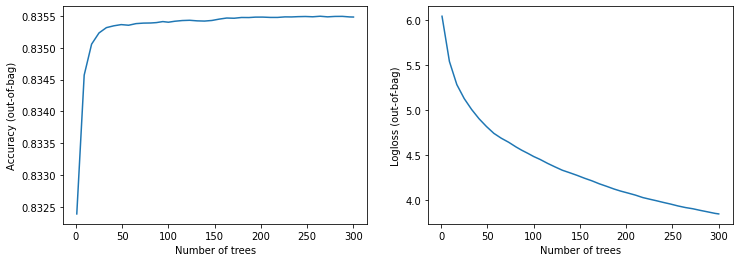

In [29]:
trainingLogs(model5)

Adding all parameters seems to be a better choice than simplifying the model.

Since for the simplified version of the model we got better results for the GBT model, we should normally get better results for the full model as well.

So let's try to train the full dataset with the GBT model to see if we get even better results:

In [10]:
model_gbt3 = tfdf.keras.GradientBoostedTreesModel()

Use /tmp/tmp2fr90xjc as temporary training directory


In [11]:
model_gbt3.fit(train_tf)

Starting reading the dataset
1998/2000 [============================>.] - ETA: 0s
Dataset read in 0:00:13.743258
Training model
Model trained in 0:11:05.645783
Compiling model
2000/2000 [==============================] - 679s 339ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [6]:
model_gbt3.compile(metrics=["accuracy"])
print(model_gbt3.evaluate(cv_tf))

200/200 [==============================] - 1s 6ms/step - loss: 0.0000e+00 - accuracy: 0.8348
[0.0, 0.8347650170326233]


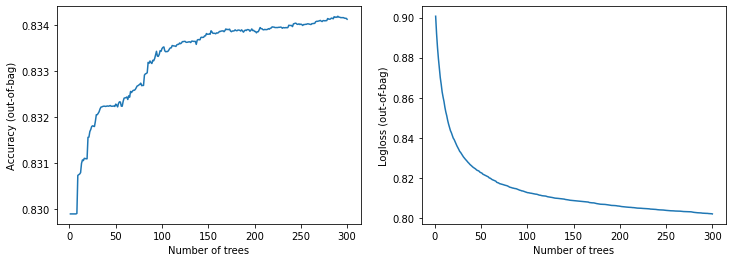

In [14]:
trainingLogs(model_gbt3)

The performance of this model is slightly better than the best model of the the simplified dataset.

In [16]:
model_gbt3.save("project/ctr_gbt3_simp_model")

INFO:tensorflow:Assets written to: project/ctr_gbt3_simp_model/assets


INFO:tensorflow:Assets written to: project/ctr_gbt3_simp_model/assets


## 9. Predictions on test dataset<a id="9"></a>

This part is optional because we can only submit the dataset and we cannot compare with the actual results of the test dataset (the "click" column does not exist on this dataset).

Loading the test dataframe:

In [43]:
dtypes_converter = {
    'id': np.dtype(str),
    'hour': str,
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21': np.dtype(int)
}

In [44]:
dparser = lambda val : pd.datetime.strptime(val, '%y%m%d%H')

In [45]:
with gzip.open('test.gz') as f:
    test = pd.read_csv(f, parse_dates=["hour"], date_parser=dparser, dtype=dtypes_converter)

/tmp/ipykernel_26258/468534682.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  dparser = lambda val : pd.datetime.strptime(val, '%y%m%d%H')


In [46]:
test_id=test[['id']]

In [47]:
test_id.dtypes

id    object
dtype: object

In [48]:
drop_feat(test,['id'])

In [49]:
split_hour_week(test)

In [50]:
hash_converter(test)

In [51]:
test.head()

,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21,actual_hour,weekday
0,1005,0,22307138,80559710,40734557,37182048,89821421,35582241,59130274,84093956,88663018,1,0,8330,320,50,761,3,175,100075,23,0,4
1,1005,0,30088808,87978715,33432265,37182048,89821421,35582241,59130274,13498033,62729153,1,0,22676,320,50,2616,0,35,100083,51,0,4
2,1005,0,30088808,87978715,33432265,37182048,89821421,35582241,59130274,44641628,3770975,1,0,22676,320,50,2616,0,35,100083,51,0,4
3,1005,0,64750755,50673893,23282419,19616185,42234095,40003476,59130274,83120233,74814805,1,0,18648,320,50,1092,3,809,100156,61,0,4
4,1005,0,64750755,50673893,23282419,4735826,23029164,4489524,59130274,68424788,3770975,1,0,23160,320,50,2667,0,47,-1,221,0,4


In [52]:
test_id.head()

,id
0,10000174058809263569
1,10000182526920855428
2,10000554139829213984
3,10001094637809798845
4,10001377041558670745


Save to a .csv file (if needed):

In [53]:
test.to_csv("test_kaggle.csv", index = False)
test_id.to_csv("test_id_kaggle.csv", index = False)

Read the .csv file (if necessary):

In [55]:
test=pd.read_csv('test_kaggle.csv')
test_id=pd.read_csv('test_id_kaggle.csv')

Convert to a tensorflow dataset:

In [23]:
test_tf = tfdf.keras.pd_dataframe_to_tf_dataset(test)

Using the most accurate model to make the predictions:

In [24]:
predictions = model_gbt3.predict(test_tf)

Creating the predictions dataset with the id column:

In [57]:
test_predictions = test_id

In [26]:
test_predictions['click']=predictions

In [3]:
test_predictions.shape

(4577464, 2)

In [68]:
test_predictions.head()

,id,click
0,10000174058809263569,0.068576
1,10000182526920855428,0.064176
2,10000554139829213984,0.049946
3,10001094637809798845,0.039663
4,10001377041558670745,0.019619


Save to a .csv file (if needed):

In [65]:
test_predictions.to_csv("test_predictions_kaggle.csv", index = False)

Read the .csv file (if necessary):

In [58]:
test_predictions=pd.read_csv('test_predictions_kaggle.csv')

Submit the results to kaggle website:

In [64]:
!kaggle competitions submit -c avazu-ctr-prediction -f test_predictions_kaggle.csv -m "my submision"

100%|████████████████████████████████████████| 139M/139M [00:26<00:00, 5.42MB/s]
Successfully submitted to Click-Through Rate Prediction

## 10. Conclusions<a id="10"></a>

With this project we were able to create several models of decion trees with the help of tensorflow random forests algorithms.

We tried multiple approaches and evaluated their performance on a cross-validation set before testing on the test dataset.

The Gradient Boosted Trees learning algorithm appeared to perform better than the Random Forest learning algorithm. In addition, the hyperparameter used to tune the model did not appear to improve too much the models.

Similarly, the "complete dataset" (with 24 features) seemed to obtain better models than the "simple" one with (14 features), but with the BGT algorithm, the performance of both models was very close.

For future improvements, I suggest working on the simplified version of the model and trying other hyperparameters combined with the existing ones and trying to improve the GBT model (or trying a new tensorflow-decision-forests model).

Some other models available on tfdf are:

In [84]:
tfdf.keras.get_all_models()

[tensorflow_decision_forests.keras.RandomForestModel,
 tensorflow_decision_forests.keras.GradientBoostedTreesModel,
 tensorflow_decision_forests.keras.CartModel,
 tensorflow_decision_forests.keras.DistributedGradientBoostedTreesModel]

Another option is to get a larger dataset by extracting small epochs based on the 40milion dataset, and then iterating on these to get even more decision trees. The problem is that this option can be very time consuming, but can be solved by taking the right epoch size and the right number of epochs.